# RNAqa output analysis

In [138]:
!pip3 install xmltodict biopython tqdm

In [160]:
import xmltodict
import glob
import os
import traceback
from tqdm import tqdm
from Bio.PDB import PDBParser
from Bio.PDB import PDBIO
class Structure:
    rmsd=[]
    residues=0
    chains=[]
    name=''
    error=0
    def __hash__(self):
        return self.i
    def __eq__(self, other):
        if isinstance(other, Structure):
            return self.i == other.i
        return False

    def __init__(self,path,i):
        self.i=i
        self.rmsd=[]
        self.residues=0
        self.error=0
        self.chains=[]
        self.name=[]
        directory = path.split('/')[-1].split('.')[0]
        with open(path) as f:
            for i in xmltodict.parse(f.read())['results']['result']['measureScores']['structure']:        
                if 'errors' in i['description']:
                    self.error+=1
                else:
                    if float(i['score'])<60:
                        self.rmsd.append(float(i['score']))
                        if not os.path.exists('/tmp/result/'+'_'.join(i['description']['filename'].split('_')[0:3])+'/'+i['description']['filename']):
                            raise Exception('File not exists ','/tmp/result/'+'_'.join(i['description']['filename'].split('_')[0:3])+'/'+i['description']['filename'])
                        if self.name==[]:
                            parser=PDBParser(QUIET=True)
                            struct = parser.get_structure('str','/tmp/result/'+'_'.join(i['description']['filename'].split('_')[0:3])+'/'+i['description']['filename'])
                            for chain in struct[0]:
                                self.chains.append(chain.get_id())
                                self.residues+=len(chain)
                        self.name.append(i['description']['filename'])

xmls=tqdm(glob.glob("/tmp/result/*.xml"))
structures =[]
for i,xml in enumerate(xmls,i):
    try:
        s=Structure(xml,i)
        structures.append(s)
    except Exception:
        print(traceback.format_exc())
    

 63%|██████▎   | 462/739 [00:10<00:05, 52.66it/s]

Traceback (most recent call last):
  File "/tmp/ipykernel_346860/126119141.py", line 50, in <module>
    s=Structure(xml,i)
      ^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_346860/126119141.py", line 30, in __init__
    for i in xmltodict.parse(f.read())['results']['result']['measureScores']['structure']:
     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
KeyError: 'results'



100%|██████████| 739/739 [00:16<00:00, 43.99it/s]

Traceback (most recent call last):
  File "/tmp/ipykernel_346860/126119141.py", line 50, in <module>
    s=Structure(xml,i)
      ^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_346860/126119141.py", line 30, in __init__
    for i in xmltodict.parse(f.read())['results']['result']['measureScores']['structure']:
     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
KeyError: 'results'



### Strucutres with errors

In [7]:
len([i.residues for i in structures if i.residues==0])

2

In [107]:
len([i.name for i in structures if i.error>0])
# [i.name for i in structures if i.error>0]

2

### Min rmsd

In [117]:
min([min(i.rmsd) for i in structures if i.error==0])

0.268

### Max rmsd

In [119]:
max([max(i.rmsd) for i in structures if i.error==0])

58.753

### RMSD & seq len

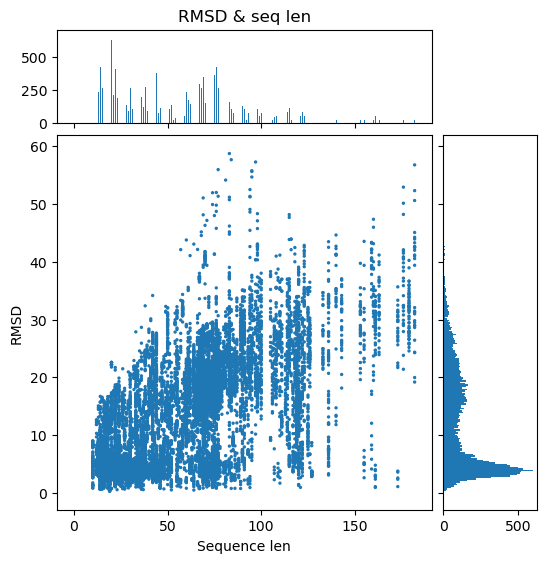

In [161]:
import matplotlib.pyplot as plt
import numpy as np
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y,s=[2 for n in range(len(x))])

    # now determine nice limits by hand:
    binwidth = 0.25
    binsx = np.arange(0, np.max(np.abs(x)) + binwidth, binwidth)
    binsy = np.arange(0, np.max(np.abs(y)) + binwidth, binwidth)
    ax_histx.hist(x, bins=binsx)
    ax_histy.hist(y, bins=binsy, orientation='horizontal')

fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.set_title('RMSD & seq len')
ax.set_ylabel('RMSD')
ax.set_xlabel('Sequence len')
x=[]
y=[]
for i in structures:
    x.extend([i.residues for z in range(len(i.rmsd))])
    y.extend(i.rmsd)
scatter_hist(x, y, ax, ax_histx, ax_histy)

### AVG structure RMSD

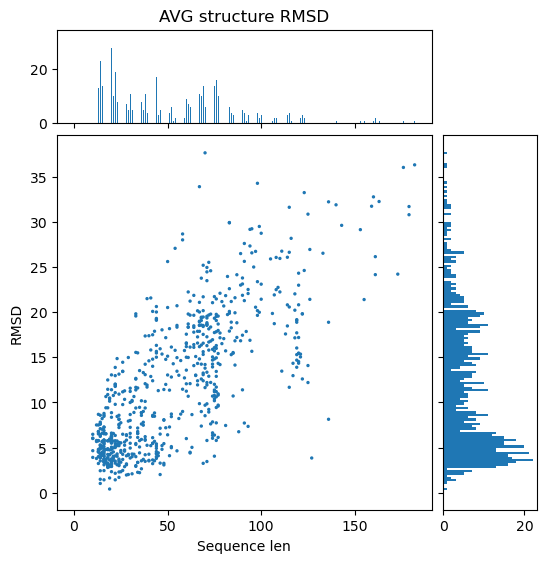

In [162]:
import matplotlib.pyplot as plt
import numpy as np
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y,s=[2 for n in range(len(x))])

    # now determine nice limits by hand:
    binwidth = 0.25

    binsx = np.arange(0, np.max(np.abs(x)) + binwidth, binwidth)
    binsy = np.arange(0, np.max(np.abs(y)) + binwidth, binwidth)
    ax_histx.hist(x, bins=binsx)
    ax_histy.hist(y, bins=binsy, orientation='horizontal')
def plot_hist(structures):
    fig = plt.figure(figsize=(6, 6))
    
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    ax_histx.set_title('AVG structure RMSD')
    ax.set_ylabel('RMSD')
    ax.set_xlabel('Sequence len')
    x=[]
    y=[]
    for i in structures:
        if i.residues>0:
            x.append(i.residues)
            y.append(np.mean([f for f in i.rmsd if f<65]))
    scatter_hist(x, y, ax, ax_histx, ax_histy)
plot_hist(structures)

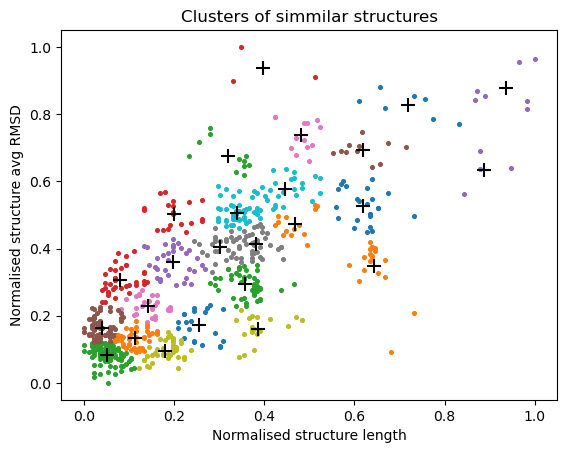

<Figure size 640x480 with 0 Axes>

In [163]:
from sklearn.cluster import KMeans
import random,math
import numpy as np
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X=[]
for i in structures:
    if i.error==0:
        X.append([i.residues,np.mean([f for f in i.rmsd if f<65])])
X=np.asarray(X)
X1=min_max_scaler.fit_transform(X)
kmeans = KMeans(n_clusters=25, random_state=0, n_init="auto").fit(X1)
class_centers, classification = kmeans.cluster_centers_, kmeans.labels_
to=[[] for i in range(len(class_centers))]
classification=np.array(classification)
for i in range(len(class_centers)):
  to[i]=X1[classification==i]
def visualize_clusters(clusters, centroids):
    #clusters: list of numpy arrays (each array with examples in one cluster)
    #centroids: numpy array
    for c in clusters:
        plt.scatter(c[:,0], c[:,1],s=7)
    plt.scatter(centroids[:,0], centroids[:,1], marker='+', color='black', s=100)
    plt.xlabel('Normalised structure length')
    plt.ylabel('Normalised structure avg RMSD')
    plt.title('Clusters of simmilar structures')
    plt.show()
    plt.savefig('groups.png')
visualize_clusters(to,np.asarray(class_centers))

groups=dict({'train':[],'val':[],'test':[]})
for i in range(len(class_centers)):
    group=set([structures[j] for j in (classification==i).nonzero()[0].tolist()])
    train = set(random.choices(list(group),k=math.ceil(len(group)*0.90)))
    group=group-train
    groups['train'].extend(list(train))
    test = set(random.choices(list(group),k=math.ceil(len(group)/2)))
    val=group-test
    groups['val'].extend(list(val))
    groups['test'].extend(list(test))

In [157]:

d=len(groups['val'])+len(groups['test'])+len(groups['train'])
print(len(groups['train'])/d)
print(len(groups['val'])/d)
print(len(groups['test'])/d)

0.6040816326530613
0.22857142857142856
0.1673469387755102


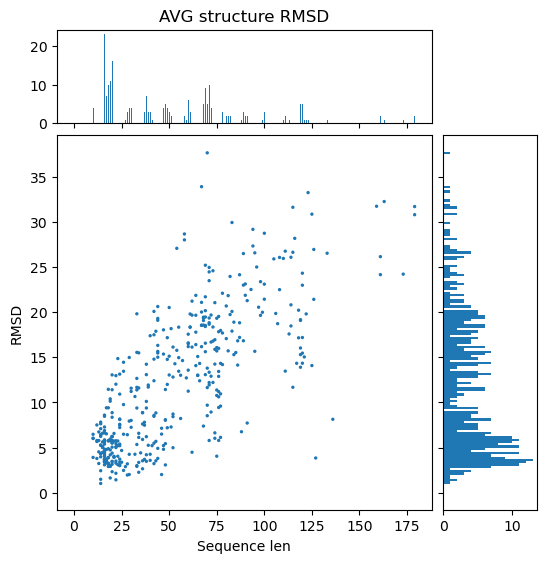

In [152]:
plot_hist(groups['train'])

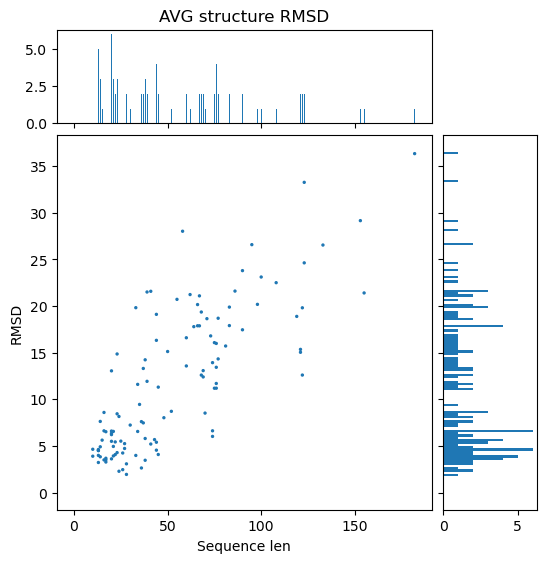

In [123]:
plot_hist(groups['val'])

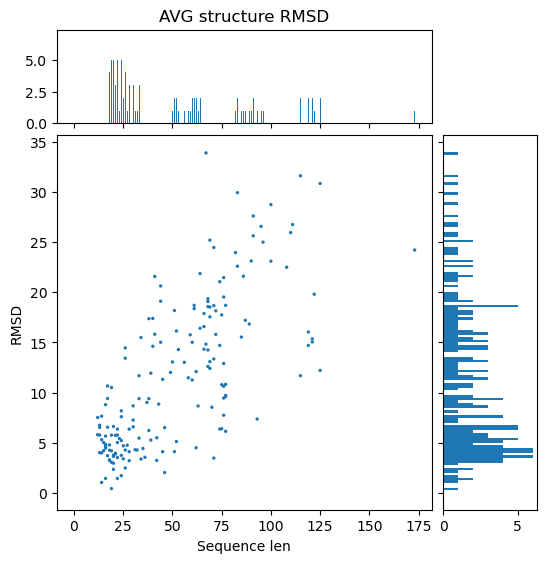

In [114]:
plot_hist(groups['test'])

# Dump groups to csv

In [158]:
def dump_group_to_csv(groups, group_str):
    with open(group_str+'.csv','w') as file_csv:
        file_csv.write('rew_rmsd,description\n')
        for structure in groups[group_str]:
            for i in range(len(structure.rmsd)):
                file_csv.write("{},{}\n".format(str(structure.rmsd[i]),structure.name[i]))
        

In [159]:
dump_group_to_csv(groups,'train')
dump_group_to_csv(groups,'val')
dump_group_to_csv(groups,'test')

### RMSD 

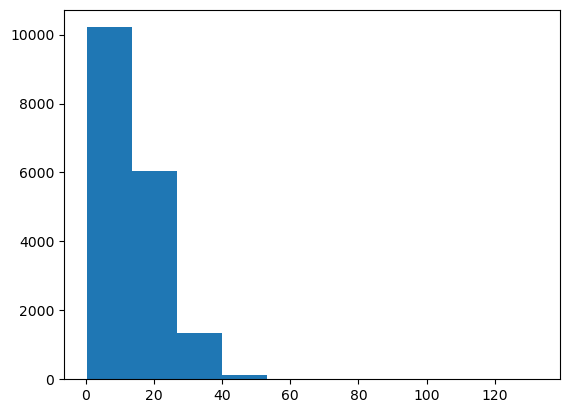

In [83]:
rmsd=[]
for i in structures:
    rmsd.extend(i.rmsd)
plt.hist(rmsd)
plt.show()

### Sequence length

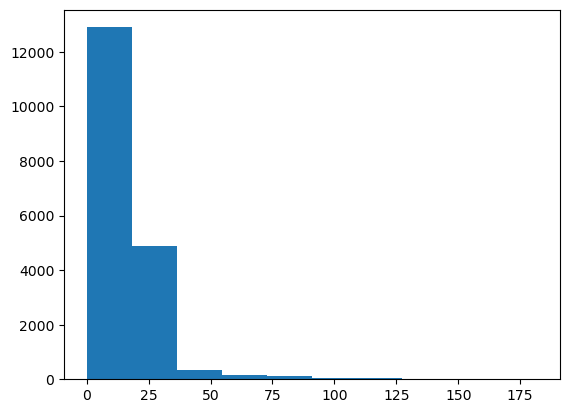

In [164]:
length=[]
for i in structures:
    rmsd.append(i.residues )
plt.hist(rmsd)
plt.show()